# A moving ball - A Multimesh Motivation


This notebook contains an comparasion of a single-mesh and multimesh approach for a ball moving with a constant speed in a channel.
We start by importing the packages needed.

In [1]:
from dolfin import *
import matplotlib.pyplot as plt

We then create a single mesh, describing an obstacle in a channel, with *pygmsh* and *gmsh*, and convert it to a dolfin readable format using *meshio*. We use the functions located in **motivation_meshes.py
** to create the meshes.

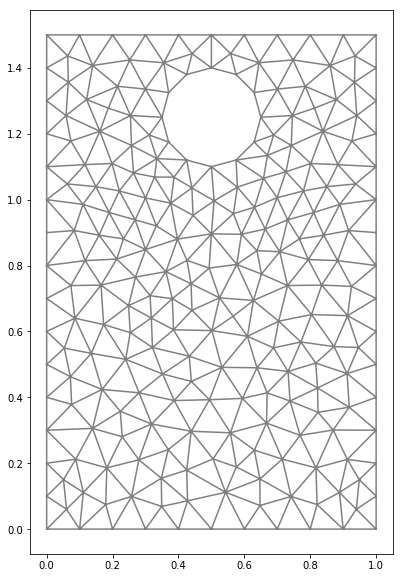

In [2]:
%load_ext autoreload
from motivation_meshes import single_mesh, background_mesh, front_mesh, outer_marker, inner_marker
single_mesh(0.1)
mesh = Mesh()
with XDMFFile("singlemesh.xdmf") as infile:
    infile.read(mesh)
mvc = MeshValueCollection("size_t", mesh, 1)
with XDMFFile("mf_singlemesh.xdmf") as infile:
    infile.read(mvc, "name_to_read")
mf = cpp.mesh.MeshFunctionSizet(mesh, mvc)

%matplotlib inline
plt.figure(figsize=(10,10))
plot(mesh)
plt.show()

Thereafter, we create a function describing the velocity field of the ball. To only create a vector field that
is non-zero on the ball, we use a *DirichletBc*.

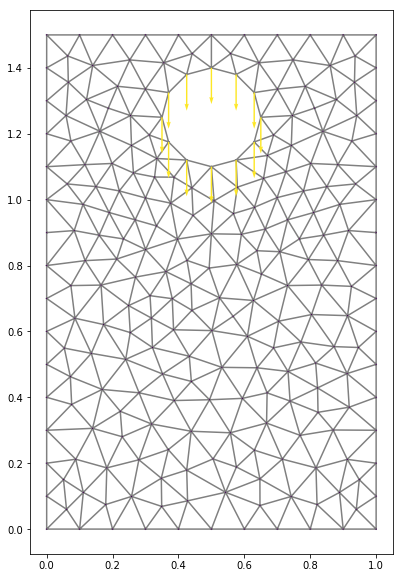

(0.6984894479044751, 0.9997674962782043)


In [3]:
V = VectorFunctionSpace(mesh, "CG", 1)
velocity = Function(V)
bc_v = DirichletBC(V, Constant((0,-0.1)), mf, inner_marker)
bc_v.apply(velocity.vector())
plt.figure(figsize=(10,10))
plot(mesh, zorder=0)
plot(velocity,zorder=1, color="b",scale=1)
plt.show()
print(MeshQuality.radius_ratio_min_max(mesh))

When the ball starts falling, we need to update the mesh. We use a smoothed $H^1(\Omega)$-representation of the function that is $(0,-0.02)$ on the ball and $(0,0)$ on the outer boundaries.

In [4]:
# Chooste timestep used in deformation
dt = 0.1
# Set boundary conditions for velocity field
b_outer = DirichletBC(V, Constant((0,0)), mf, outer_marker)
bc_displacement = DirichletBC(V, dt*velocity, mf, inner_marker)
bcs = [b_outer, bc_displacement]
u, v = TrialFunction(V), TestFunction(V)
# Smoothed H1 representation as variational form
a = 0.1*inner(grad(u), grad(v))*dx + inner(u,v)*dx
l = inner(Constant((0,0)),v)*dx
displacement = Function(V)

We define a function for the falling ball until time `t=T_end` as

In [9]:
%matplotlib inline
def falling_ball(T_end):
    fig = plt.figure(figsize=(10,10))
    org_position=mesh.coordinates().copy()
    # Compute displacement field at time t
    t_0 = 0
    while t_0<=T_end:
        A, L = assemble(a), assemble(l)
        [bc.apply(A, L) for bc in bcs]
        solve(A, displacement.vector(), L)
        # Move mesh
        ALE.move(mesh, displacement)
        t_0+=dt
    plot(mesh, color="r")
    plt.show()
    mesh.coordinates()[:]=org_position


With the slider below, one can explore how the mesh changes as the ball moves

In [10]:
from ipywidgets import interact
import ipywidgets as widgets
interact(falling_ball, T_end=(0,10,0.5))

interactive(children=(FloatSlider(value=5.0, description='T_end', max=10.0, step=0.5), Output()), _dom_classes…

<function __main__.falling_ball(T_end)>

As we can observe from the images above, the mesh degenerates with large movements, and the mesh-deformation is time-consuming.
We therefore introduce another way of representing the ball, namely with **Multiple meshes**.
We import two different meshes from *motivation_meshes.py*


In [12]:
%matplotlib notebook
front_mesh(0.1)
background_mesh(0.1)
mesh_files = ["background_mesh.xdmf", "front_mesh.xdmf"]
mf_files = ["mf_background.xdmf", "mf_front.xdmf"]
# We create the MultiMesh object containing both meshes
multimesh = MultiMesh()
mfs = []
for i in range(2):
    mesh = Mesh()
    with XDMFFile(mesh_files[i]) as infile:
        infile.read(mesh)
        multimesh.add(mesh)
    mvc = MeshValueCollection("size_t", mesh, 1)
    with XDMFFile(mf_files[i]) as infile:
        infile.read(mvc, "name_to_read")
    mfs.append(cpp.mesh.MeshFunctionSizet(mesh, mvc))

We now visualize the meshes in the `MultiMesh`-object

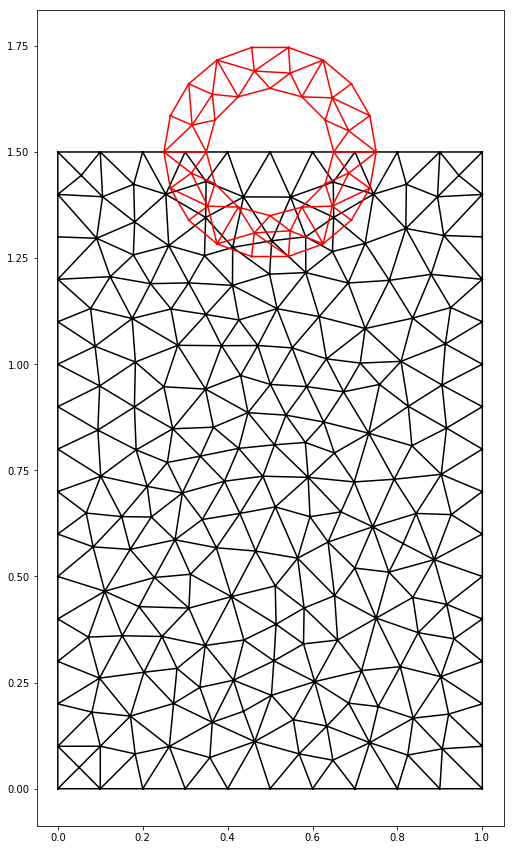

In [16]:
%matplotlib inline
colors = ["k", "r"]
fig = plt.figure(figsize=(15,15))
for i in range(multimesh.num_parts()):
    plot(multimesh.part(i), zorder=i, color=colors[i])
plt.show()

We create a hierarchy of meshes, namely a MultiMesh

In [ ]:
multimesh = MultiMesh()
multimesh.add(backgroundmesh)
multimesh.add(front)
import numpy
print([MeshQuality.radius_ratio_min_max(multimesh.part(0))
                ,MeshQuality.radius_ratio_min_max(multimesh.part(1))])


We compute the intersections between the two meshes 

In [ ]:
multimesh.build()

Without mesh-deformation, we can let the ball fall

In [ ]:
fig, ax1 = plt.subplots(1, 1)
y=2
for i in range(N):
    plt.cla()
    front.translate(Point(0, -0.02))
    y-=0.02
    multimesh.build()
    plot(multimesh.part(0), backend="matplotlib")
    plot(multimesh.part(1), backend="matplotlib", color="k")
    plt.title("Iteration: %d" %i)
    plt.axis([0,2,0,3])
    circ = plt.Circle((1, y), radius=0.51, color='w', zorder=1000)
    ax1.add_patch(circ)
    #facet_plot_edge(facets_front,front, markers=[2])
    fig.canvas.draw()    
    print([MeshQuality.radius_ratio_min_max(multimesh.part(0))
                ,MeshQuality.radius_ratio_min_max(multimesh.part(1))])


This method is both faster and more stable than the single-mesh deformation approach. Finally, we save the final multimesh as an svg-file.

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(1, 1)
plot(multimesh.part(0))
plot(multimesh.part(1), color='k')
circ = plt.Circle((1, 1), radius=0.51, color='w', zorder=1000)
ax.add_patch(circ)
ax.set_frame_on(False)
ax.set_xticks([]); ax.set_yticks([])
# ax.set_xlabel('T=1',size=20)
plt.axis([0,2,0,3])
plt.savefig("MM_fin.eps",bbox_inches='tight')
plt.close()
%matplotlib notebook